In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append(os.path.abspath('../'))

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

IMG_FOLDER = "notebooks/impresso_img/"
json_file_path = f'{IMG_FOLDER}/NZG-1881-10-01-a-p0001.json'
image_file_path = f'{IMG_FOLDER}/NZG-1881-10-01-a-p0001.jp2'

In [2]:
os.chdir("../")
#os.getcwd() # must point to project root (LoCoBench)

## Embedding with GTE

In [3]:
import json
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Initialize the model
model_name = "Alibaba-NLP/gte-multilingual-base"
#model = SentenceTransformer(model_name, trust_remote_code=True)

from src.locobench.core.embedder import TextEmbedder
text_embedder = TextEmbedder(model_name) # uncalibrated model
text_embedder_clb = TextEmbedder(model_name, apply_attn_calibration=True, calib_layers="last_half", calib_source_tokens="cls", calib_basket_size=128) # calibrated model


Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading model using eager attn to support calibration


Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def extract_paragraph_texts_and_coords(json_file):
    """
    Extracts paragraph texts and coordinates from a JSON file.

    Args:
        json_file (str): Path to the JSON file.

    Returns:
        list of tuples: Each tuple contains the text and coordinates (x, y, width, height) of a paragraph.
    """
    paragraphs = []
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    for page in data.get('r', []):
        for paragraph in page.get('p', []):
            text = ' '.join(token.get('tx', '') for line in paragraph.get('l', []) for token in line.get('t', []))
            coords = paragraph.get("c", None)
            if text and coords and len(text)> 100:
                paragraphs.append((text, coords))

    return paragraphs

def create_heatmap(json_file, image_file, model, seed=1):
    """
    Creates a heatmap based on cosine similarity between paragraph embeddings and the document embedding.

    Args:
        json_file (str): Path to the JSON file containing paragraph coordinates and text.
        image_file (str): Path to the image file.
        model: Embedding model that exposes an 'encode' method.
        seed (int): Random seed for shuffling paragraphs.
    """
    # Extract paragraphs and coordinates
    paragraphs = extract_paragraph_texts_and_coords(json_file)
    # random.seed(seed)
    # random.shuffle(paragraphs)
    # print(paragraphs)
    # Extract paragraph texts and shuffle
    paragraph_texts = [text for text, _ in paragraphs]

    # Aggregate paragraph_text into articles (for document embedding)
    # article 1: paragraphs 0,1,5
    # article 2: paragraphs 6,7,8
    # article 3: paragraphs 2,3,4
    article_texts = [
        "\n".join(paragraph_texts[i] for i in [0, 1, 5]),
        "\n".join(paragraph_texts[i] for i in [6, 7, 8]),
        "\n".join(paragraph_texts[i] for i in [2, 3, 4]),
        
    ]
    paragraph2article_map = {0: 0, 1: 0, 5: 0, 6: 1, 7: 1, 8: 1, 2: 2, 3: 2, 4: 2}

    # Calculate document embedding
    #document_text = "\n\n\n".join(paragraph_texts)
    document_text = "\n\n\n".join(article_texts)

    document_embedding = model.encode([document_text], normalize_embeddings=True)[0]

    # Calculate paragraph embeddings and cosine similarity with document embedding
    heatmap_data = np.zeros(Image.open(image_file).size[::-1])  # Height, Width
    similarities = []

    for i, (text, (x, y, w, h)) in enumerate(paragraphs):
        text = article_texts[paragraph2article_map[i]]
        paragraph_embedding = model.encode([text], normalize_embeddings=True)[0]
        similarity = cos_sim(paragraph_embedding, document_embedding).item()
        similarities.append(similarity)
        heatmap_data[y : y + h, x : x + w] = (
            similarity  # Update heatmap based on similarity
        )

    # Load image and overlay heatmap
    img = Image.open(image_file)
    plt.figure(figsize=(15, 15))
    plt.imshow(img, extent=[0, img.width, img.height, 0])
    plt.imshow(
        heatmap_data, cmap="YlOrRd", alpha=0.5, extent=[0, img.width, img.height, 0], vmin=0.5, vmax=1.0
    )

    # Overlay similarity values as text (identical styling to reference)
    for similarity, (i, (x, y, w, h)) in zip(
        similarities, [(i, coords) for i, (_, coords) in enumerate(paragraphs)]
    ):
        if i not in [0,6,2]:  # only label the first paragraph of each article
            continue
        plt.text(
            x + w / 2,
            y + h / 2,
            f"{similarity:.2f}",
            ha="center",
            va="center",
            fontsize=12,
            color="white",
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.3"),
        )

    # Overlay shuffled index at the upper-left corner of each paragraph's box
    for idx, (_, (x, y, w, h)) in enumerate(paragraphs):
        if idx not in [0,6,2]:  # only label the first paragraph of each article
            continue
        plt.text(
            x + 2,
            y + 2,
            f"{paragraph2article_map[idx]+1}",
            ha="left",
            va="top",
            fontsize=12,
            color="white",
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.3"),
        )
    plt.colorbar()
    plt.axis("off")
    plt.show()

# Uncalibrated Page Embedding

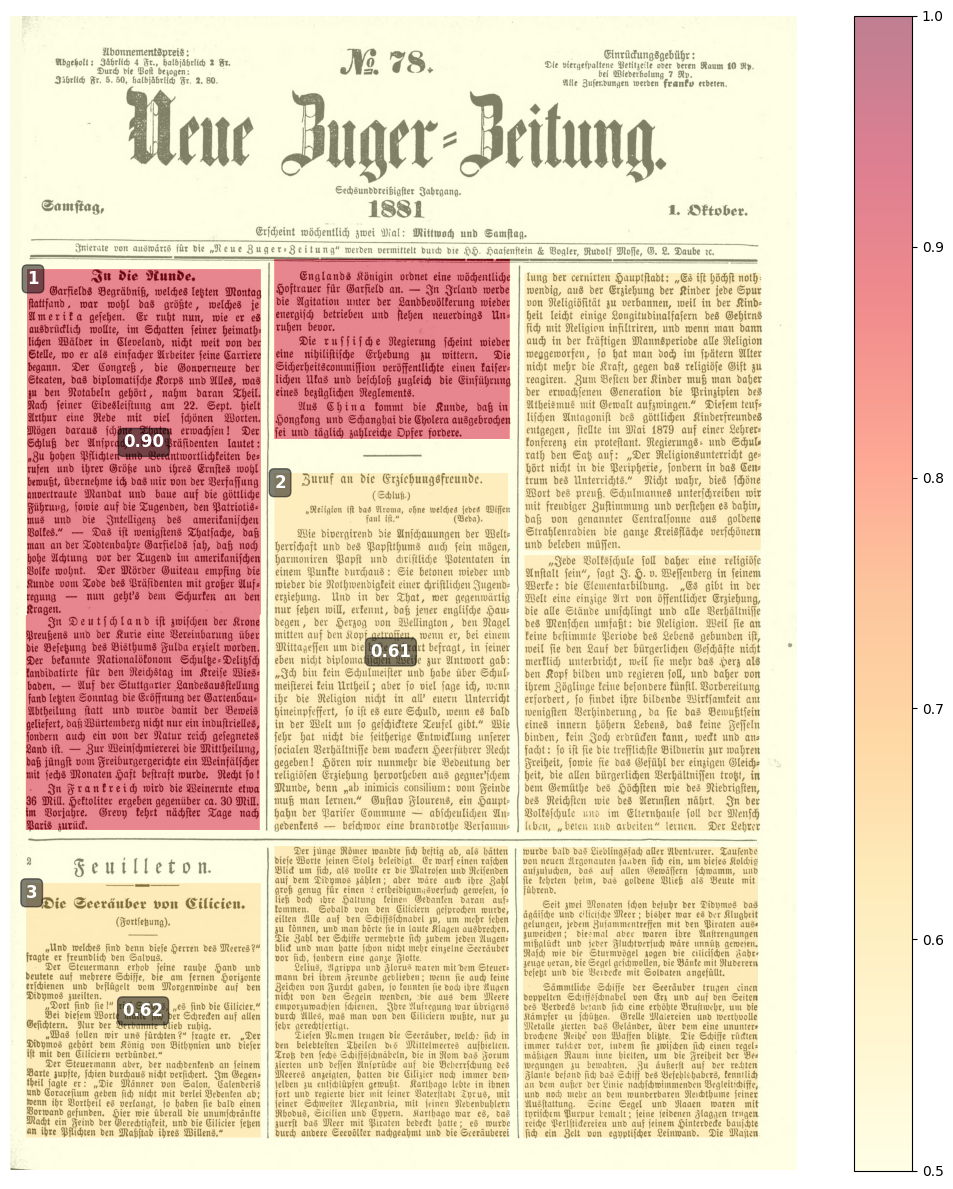

In [5]:
create_heatmap(json_file_path, image_file_path, text_embedder, seed=1)

# Calibrated Page Embedding

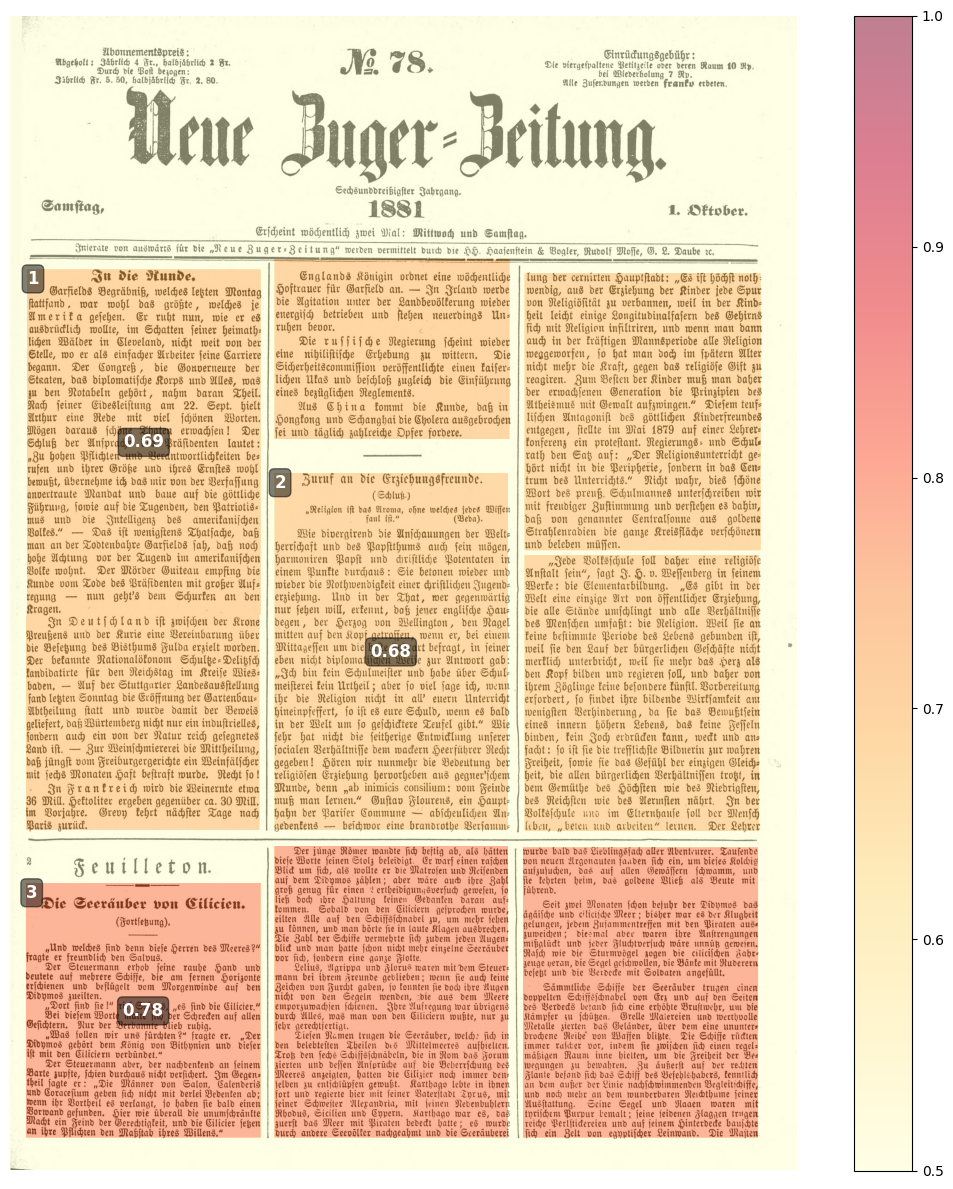

In [6]:
create_heatmap(json_file_path, image_file_path, text_embedder_clb, seed=1)